### Loan Grades

**Objective**:  
After completing part one of our modeling, we developed a machine learning model to classify loans as accepted/rejected. Now that we have automated that process, we are moving onto our next task, which involves predicting the loan grade for our accepted loans. We will be taking a similar approach as we did in Part 1, which involves exploring our data,understanding which factors play a role in the grade of a loan, and building a model to automate this process as well.

**Imports & Data Overview**

In [1]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, precision_recall_curve,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tqdm
from ydata_profiling import ProfileReport
import optuna

from project_utils.functions import (
    bin_by_quartiles, confusion_matrix_df, create_pipeline,
    create_preprocessor, evaluate_models, extract_feature_importances,
    get_numerical_categorical_columns, mutual_information_scores,
    null_percentages, multiple_test_chi2, compute_correlations_and_pvalues)
from project_utils.objective_functions import get_objective_xgb_multi_class
from plot_utils import annotate_bars, hide_spines

In [2]:
%load_ext autoreload
%autoreload 2
plt.style.use('deeplearning.mplstyle')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_blue = default_colors[0]

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
df_accepted = pd.read_csv('lending_club_data/accepted_cleaned.csv',
                          dtype={'zip_code': str},
                          low_memory=False)

In [5]:
float_types_accepted = df_accepted.select_dtypes(exclude='object').columns
df_accepted[float_types_accepted] = df_accepted[float_types_accepted].apply(
    lambda x: x.astype(np.float32))

**What features could we potentially use for predicting loan grade/subgrade that would be available at the time (prevent data leakage)?**

In [6]:
# All of these features represent values or dates after the loan was already issued
# or they are values that are changing within certain intervals
features_to_exclude = [
    'funded_amnt', 'funded_amnt_inv', 'loan_status', 'total_pymnt',
    'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'out_prncp',
    'out_prncp_inv', 'debt_settlement_flag', 'hardship_flag', 'id',
    'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d',
    'issue_d', 'pymnt_plan', 'initial_list_status', 'installment',
    'disbursement_method'
]
features_to_include = [
    col for col in df_accepted.columns if col not in features_to_exclude
]

In [7]:
df_accepted_subset = df_accepted[features_to_include]
df_accepted_subset.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,36.0,13.990000,C,C4,leadman,10.0,MORTGAGE,55000.0,Not Verified,debt_consolidation,190,PA,5.910000,0.0,2003-08-01,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.700001,13.0,0.0,30.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.200001,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.900002,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,36.0,11.990000,C,C1,Engineer,10.0,MORTGAGE,65000.0,Not Verified,small_business,577,SD,16.059999,1.0,1999-12-01,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.200001,38.0,0.0,NaN,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.100000,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.400002,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,60.0,10.780000,B,B4,truck driver,10.0,MORTGAGE,63000.0,Not Verified,home_improvement,605,IL,10.780000,0.0,2000-08-01,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.200001,18.0,0.0,NaN,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.900002,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.000000,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,60.0,14.850000,C,C5,Information Systems Officer,10.0,MORTGAGE,110000.0,Source Verified,debt_consolidation,076,NJ,17.059999,0.0,2008-09-01,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.600000,17.0,0.0,NaN,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.100000,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,NaN,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.000000,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,60.0,22.450001,F,F1,Contract Specialist,3.0,MORTGAGE,104433.0,Source Verified,major_purchase,174,PA,25.370001,1.0,1998-06-01,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.500000,35.0,0.0,NaN,Individual,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.500000,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.599998,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


In [8]:
null_percentages(df_accepted_subset)[null_percentages(
    df_accepted_subset).values >= 10].sort_values(ascending=False)

mths_since_last_record            84.112844
mths_since_recent_bc_dlq          77.011186
mths_since_last_major_derog       74.309596
mths_since_recent_revol_delinq    67.250447
mths_since_last_delinq            51.246025
il_util                           47.280296
mths_since_rcnt_il                40.250253
all_util                          38.322682
total_cu_tl                       38.313039
inq_last_12m                      38.313039
open_acc_6m                       38.313039
open_il_12m                       38.312995
open_il_24m                       38.312995
total_bal_il                      38.312995
open_act_il                       38.312995
open_rv_24m                       38.312995
max_bal_bc                        38.312995
inq_fi                            38.312995
open_rv_12m                       38.312995
mths_since_recent_inq             13.068521
dtype: float64

In [9]:
mnths_since_events = [
    'mths_since_last_record',
    'mths_since_recent_bc_dlq',
    'mths_since_last_major_derog',
    'mths_since_recent_revol_delinq',
    'mths_since_last_delinq',
]
for feature in mnths_since_events:
    df_accepted_subset.loc[:, f"{feature}_indicator"] = df_accepted_subset[
        feature].notnull().astype(int)

In [10]:
df_accepted_subset = df_accepted_subset.drop(columns=mnths_since_events)

In [11]:
dti_99th_percentile = df_accepted_subset['dti'].quantile(0.995)
dti_99th_percentile

53.68

In [12]:
df_accepted_subset = df_accepted_subset[
    (df_accepted_subset['dti'] < dti_99th_percentile)
    & (df_accepted_subset['dti'] > 0)]

In [13]:
df_accepted_subset['average_fico_score'] = (
    df_accepted_subset['fico_range_high'] +
    df_accepted_subset['fico_range_low']) / 2

In [17]:
df_accepted_subset['verification_status'] = df_accepted_subset[
    'verification_status'].replace('Source Verified', 'Verified')

In [14]:
df_accepted_subset['home_ownership'] = df_accepted_subset[
    'home_ownership'].replace(['ANY', 'NONE'], 'OTHER')

In [15]:
# Checking outliers for annual income
df_accepted_subset[(df_accepted_subset['annual_inc'] >= 1_000_000) & (
    df_accepted_subset['verification_status'] == 'Not Verified')][[
        'annual_inc', 'verification_status', 'emp_title', 'dti', 'loan_amnt',
        'average_fico_score', 'purpose'
    ]].head()

,annual_inc,verification_status,emp_title,dti,loan_amnt,average_fico_score,purpose
263438,1000000.0,Not Verified,CFO,13.97,21000.0,717.0,debt_consolidation
315219,7000000.0,Not Verified,owner,0.03,7500.0,707.0,car
362030,4695472.0,Not Verified,Licensed Practical Nurse (LPN),0.27,3000.0,697.0,car
678800,1110000.0,Not Verified,Citrix Administrator,16.32,12000.0,662.0,credit_card
872741,1000000.0,Not Verified,Head Coach,6.09,24175.0,667.0,credit_card


In [21]:
df_accepted_subset.to_csv('df_accepted_subset_cleaned.csv', index=False)

In [16]:
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df_accepted_subset['grade_ordinal_encoded'] = df_accepted_subset['grade'].map(
    grade_mapping)

In [21]:
profile = ProfileReport(df_accepted_subset, minimal=True)
profile.to_file(output_file="output.html")

- Before diving into our EDA and modeling, I decided to narrow down the space of features we will be using for predicting loan grades/subgrades. We need to consider which features would be available to us at the time of predicting the loan grade in order to prevent data leakage. Features like loan status, interest rate, total payment, etc. are all features that are calculated, after the loan has been issued, would not be good candidates. 

- We also investigated our null values. For some of our months since features like (mths_since_last_record,mths_since_last_major_derog,etc.), there was a significant amount of null values. The null values most likely indicate that these events have not occurred. To capture this potentially valuable information, we created indicator variables for these features. The reasoning behind using indicator variables for these specific features is to differentiate between borrowers for whom these events have never occurred (indicated by the null values) and those with a recorded event.

- Our next batch of null values were features such as open_acc_6m (Number of open trades in last 6 months), open_act_il(Number of currently active installment trades). When investigating we see that all these columns are related and when one is null all the others are null. This most likely indicates that the borrower did not have any open trades, installments, etc. During our preprocessing we will experiment with imputing these values, as they may provide useful information.

- From our last notebook (accepted/rejected) we observed some significant outliers in our debt to income ratio column. Values > 100 and less then 0. We decided to remove all values (less than 1% of our dataset) that were above the 0.995 quantile and less then 0. We created a mapping for our target variable (grade), due to the nature of the data (ordinal) it made sense to encode it in that manner.

**What is the distribution of our loan grades?**

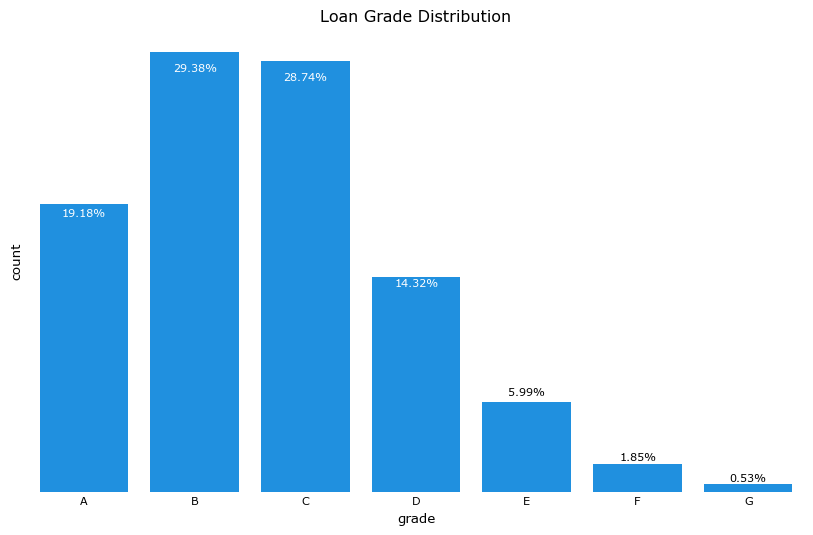

In [24]:
plt.figure(figsize=(10, 6))
plt.title('Loan Grade Distribution')
fig = sns.countplot(df_accepted_subset,
                    x='grade',
                    color=default_blue,
                    order=sorted(df_accepted_subset['grade'].unique()))
annotate_bars(fig, percentage=True)
hide_spines(fig)
plt.yticks([])
plt.show()

- Our bar plot above displays the distribution of our loan grades (the variable we will be predicting). As we can see loan grades of B(29.3%) and C(29%) make up approximately 58% of our dataset, followed by grades A (19%) and D (14%). Grades E (6%),F(1.85%), and G(0.5%) make up a much smaller proportion in our dataset.

**Feature Analysis (Loan Grade)**

In [176]:
subset = df_accepted_subset.sample(
    frac=0.3,
    random_state=42).select_dtypes(exclude=['object', 'datetime64']).drop(
        columns=['fico_range_low', 'fico_range_high', 'int_rate'])

In [180]:
spearmans_corr_df = compute_correlations_and_pvalues(subset,
                                                     'grade_ordinal_encoded',
                                                     'spearman')

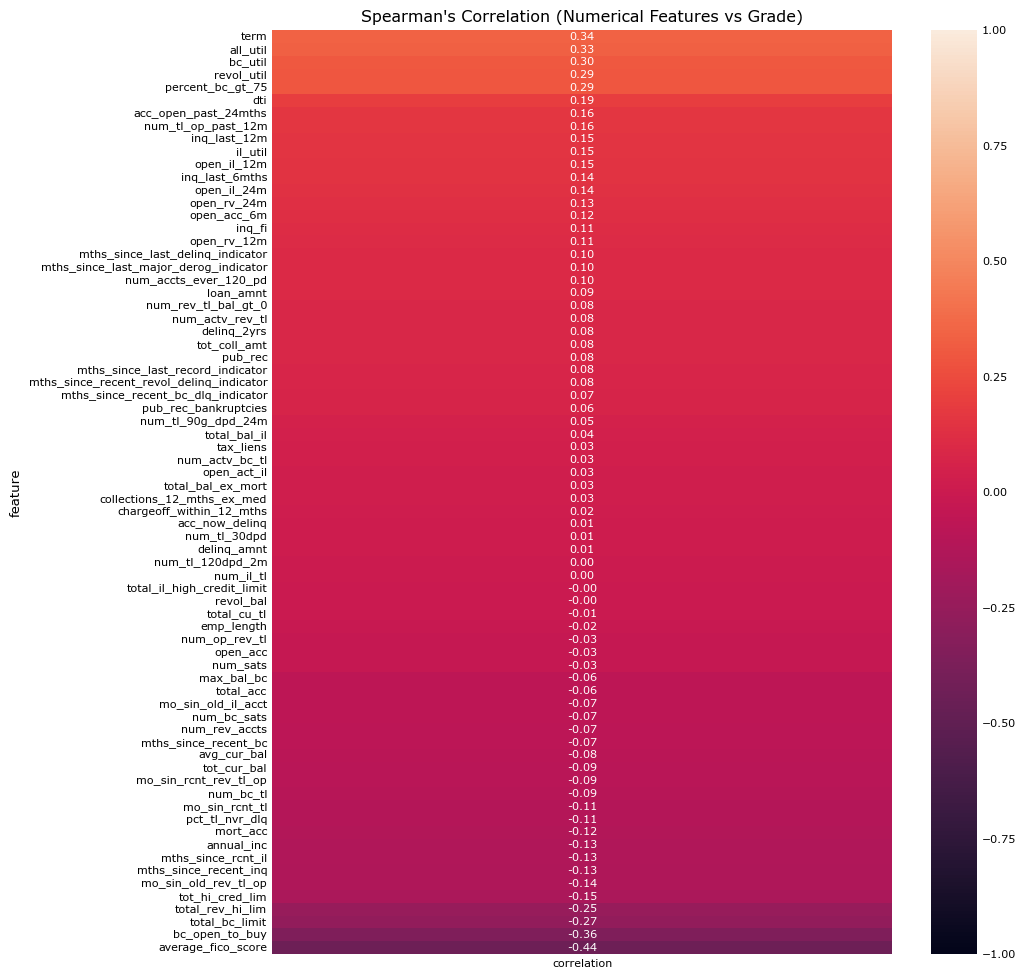

In [181]:
plt.figure(figsize=(10, 12))
sns.heatmap(spearans_corr_df.set_index('feature')[['correlation']],
            annot=True,
            fmt=".2f",
            vmin=-1,
            vmax=1)
plt.title("Spearman's Correlation (Numerical Features vs Grade)")
plt.show()

In [185]:
higher_correlated_cols = spearmans_corr_df[abs(
    spearmans_corr_df['correlation']) >= 0.2]['feature'].values

In [186]:
correlated_features_grouped = df_accepted_subset.groupby(
    'grade')[higher_correlated_cols].median().reset_index()

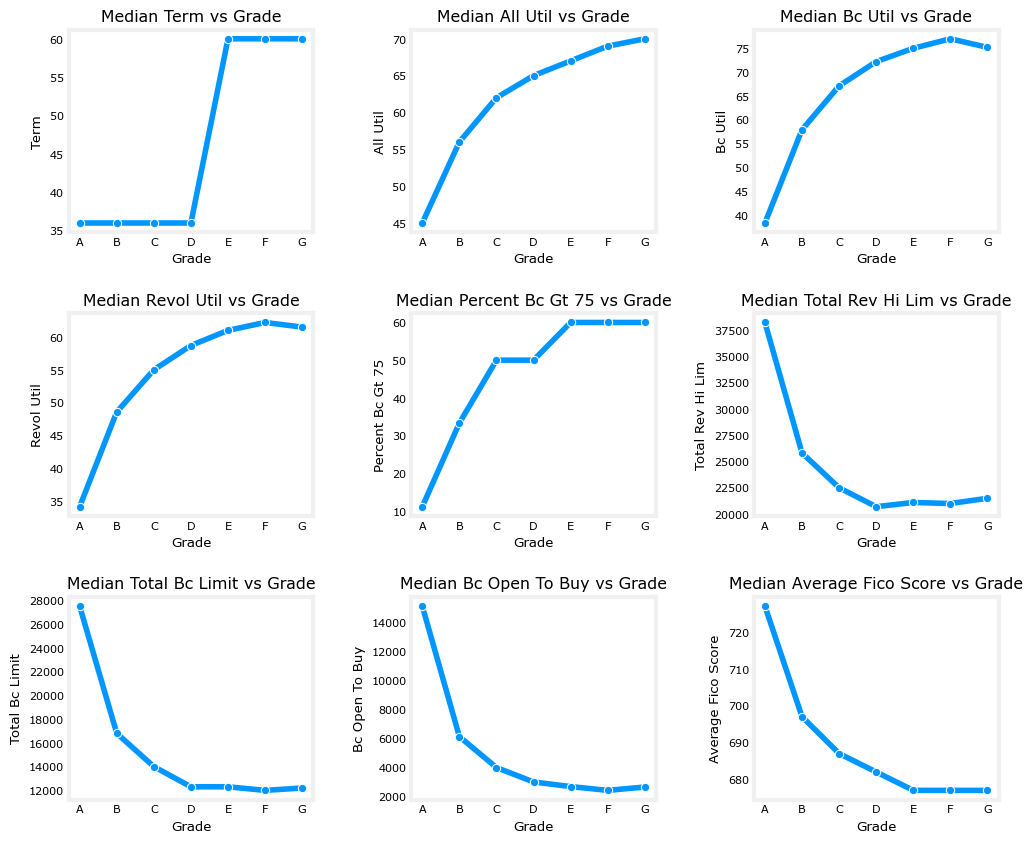

In [187]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(correlated_features_grouped.iloc[:, 1:], start=1):
    plt.subplot(3, 3, i)
    sns.lineplot(x=correlated_features_grouped['grade'],
                 y=correlated_features_grouped[col],
                 marker='o')
    plt.xlabel('Grade')
    col_formatted = col.title().replace('_', ' ')
    plt.title(f'Median {col_formatted} vs Grade')
    plt.ylabel(col_formatted)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

- Due to the large number of features in our dataset, it is not practical to plot 80+ plots against our target variable and try to visualize any patterns. Therefore, we utilized Spearman's correlation (suited for our ordinal target variable), then filtered out variables with higher correlation (negative and positive), and aggregated the results by their median values in order to visualize more important features.

- The line plots revealed insightful trends regarding the relationship between various financial metrics and the risk associated with loan grades. Features such as the loan term (either 36 or 60 months), overall utilization (the ratio of total balance to credit limit across all trades), bankcard utilization (the ratio of total current balance to the high credit/credit limit for all bankcard accounts), and the percentage of bankcard accounts exceeding 75% of their limit all show a tendency to rise with an increase in loan grade risk. On the contrary, metrics like the total revolving high credit limit, the total available credit on revolving bankcards, and the average FICO scores exhibit a decline as the loan risk escalates. These patterns display the relationship between borrowers' credit behaviour and perceived risk, as shown in their loan grades.

- Now that we have identified some features that exhibit a relationship with our target variable, we will move on to splitting and preprocessing our data.

**Data Splitting/Preprocessing (Grade)**

In [17]:
X = df_accepted_subset.drop(columns=[
    'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'emp_title',
    'int_rate', 'grade', 'grade_ordinal_encoded', 'sub_grade'
])
y = df_accepted_subset['grade_ordinal_encoded']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.075,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.075 /
                                                  (1 - 0.075),
                                                  random_state=42)

In [19]:
print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (1909032, 78)
Validation Data: (168445, 78)
Testing Data: (168445, 78)


In [27]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_val)
print(classification_report(y_val, dummy_preds))

              precision    recall  f1-score   support

           0       0.19      0.19      0.19     32314
           1       0.29      0.29      0.29     49487
           2       0.29      0.29      0.29     48407
           3       0.14      0.14      0.14     24129
           4       0.06      0.06      0.06     10095
           5       0.02      0.02      0.02      3112
           6       0.01      0.01      0.01       901

    accuracy                           0.23    168445
   macro avg       0.14      0.14      0.14    168445
weighted avg       0.23      0.23      0.23    168445



- We split our data into train, test, and validation. We did an 85/7.5/7.5 split. This leaves us with a sufficient amount of data for training as well as testing and validation. Our metric of interest for predicting loan grade will be the macro-f1-score. Why? F1-score will allow us to achieve a balance between precision and recall. Precision is important because we make sure loans are correctly classified into their respective grades, minimizing financial loss and incorrect estimations. Recall is important because we want our model to correctly identify loans that correspond to their respective grades. So, since both carry their own importance, we will be moving forward in order to improve f1.

**Mutual Information (Grade)**

In [18]:
numerical_cols, cat_cols = get_numerical_categorical_columns(X_train)

In [19]:
encoder = TargetEncoder()
numerical_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [101]:
mi_preprocessor = create_preprocessor(numerical_cols, cat_cols,
                                      numerical_imputer, cat_imputer, encoder,
                                      'passthrough')

In [34]:
sample_size = 200_000
X_train_sample = X_train[list(numerical_cols) + list(cat_cols)].sample(
    n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [35]:
mi_scores_df = mutual_information_scores(X_train_sample, y_train_sample,
                                         mi_preprocessor)

In [34]:
cat_cols_mapping = {str(i): cat_cols[i] for i in range(len(cat_cols))}

In [37]:
mi_scores_df['feature'] = mi_scores_df['feature'].replace(cat_mapping)

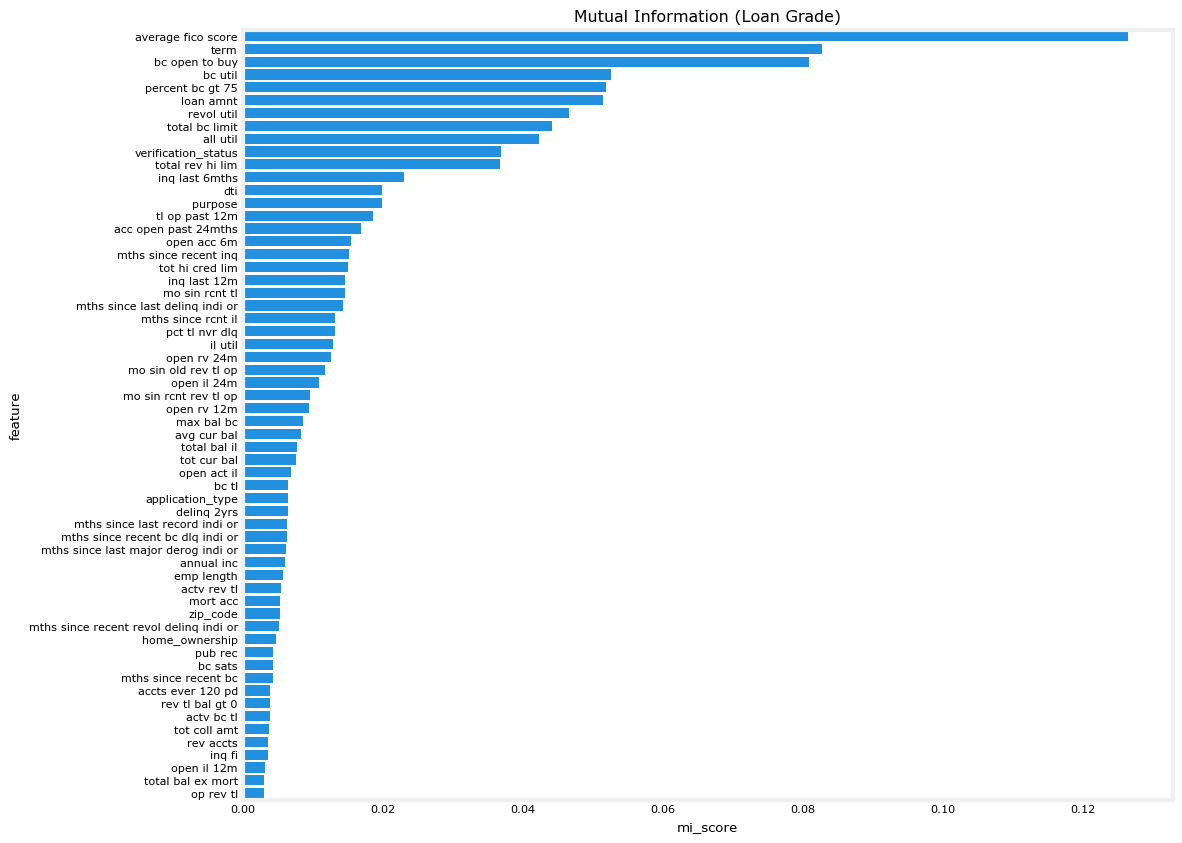

In [38]:
plt.figure(figsize=(12, 10))
plt.title('Mutual Information (Loan Grade)')
sns.barplot(mi_scores_df.head(60),
            x='mi_score',
            y='feature',
            color=default_blue)
plt.show()

- After splitting our dataset, we utilized mutual information to get a better understanding of which features could be large contributors to our model for predicting loan grades. We can see that there are a lot of similarities between this and the correlation map we plotted above. Average FICO scores have the highest scores, followed by loan term and total open to buy on revolving bankcards.

**Model Selection (Grade)**

In [22]:
models = {
    'XGBoost':
    xgb.XGBClassifier(random_state=42,
                      use_label_encoder=False,
                      eval_metric='mlogloss',
                      n_estimators=200,
                      objective='multi:softmax',
                      max_depth=6,
                      verbosity=2,
                      n_jobs=-1),
    'RandomForest':
    RandomForestClassifier(random_state=42,
                           n_estimators=200,
                           max_depth=6,
                           class_weight='balanced',
                           n_jobs=-1),
    'LinearSVM':
    SGDClassifier(random_state=42,
                  loss='hinge',
                  class_weight='balanced',
                  max_iter=10_000,
                  penalty='l2',
                  n_jobs=-1),
    'LogisticRegression':
    LogisticRegression(random_state=42,
                       class_weight='balanced',
                       multi_class='multinomial',
                       max_iter=10000,
                       n_jobs=-1)
}

In [20]:
preprocessor_tree_based = create_preprocessor(numerical_cols, cat_cols,
                                              numerical_imputer, cat_imputer,
                                              encoder, None)

preprocessor_linear = create_preprocessor(numerical_cols, cat_cols,
                                          numerical_imputer, cat_imputer,
                                          encoder, StandardScaler())

In [57]:
model_results, feature_importances = evaluate_models(models, X_train, y_train,
                                                     X_val, y_val,
                                                     preprocessor_linear,
                                                     preprocessor_tree_based)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [11:38<00:00, 174.62s/it]


In [58]:
results_df = pd.DataFrame(model_results,
                          index=['F1-Score', 'Precision', 'Recall'
                                 ]).T.reset_index().rename(columns={
                                     'index': 'Model'
                                 }).sort_values(by='F1-Score', ascending=False)

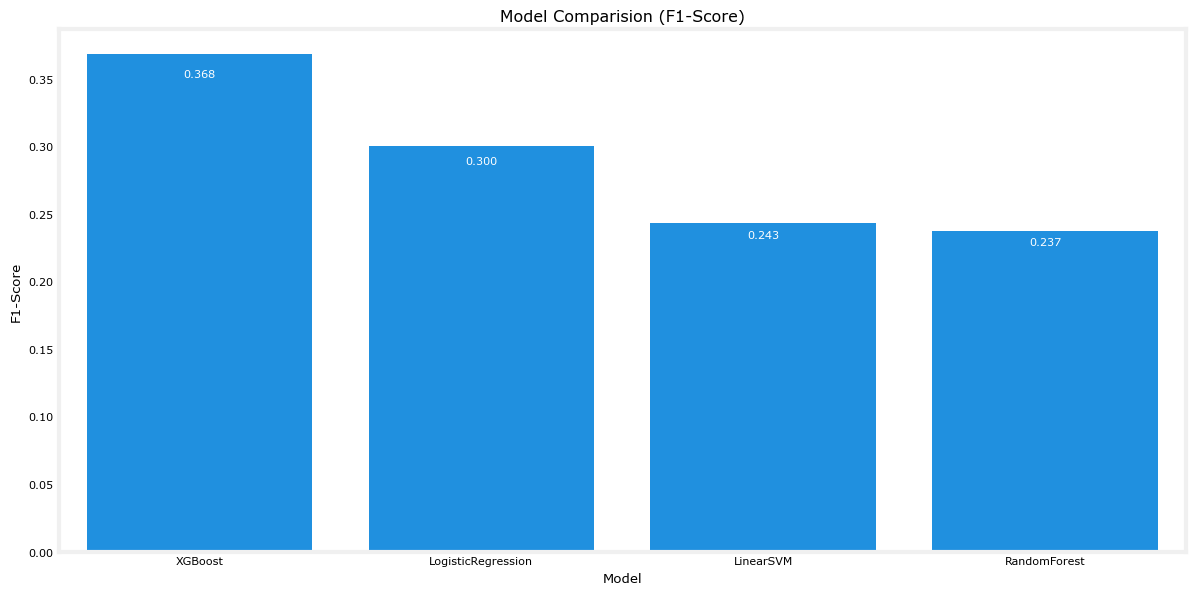

In [59]:
plt.figure(figsize=(12, 6))
plt.title('Model Comparision (F1-Score)')
fig = sns.barplot(results_df, x='Model', y='F1-Score', color=default_blue)
annotate_bars(fig)
plt.tight_layout()

In [65]:
xgb_feature_importances = feature_importances['XGBoost']
xgb_feature_importances['feature'] = xgb_feature_importances[
    'feature'].str.replace(
        "^__", "", regex=True).map(lambda x: cat_cols_mapping.get(x, x))

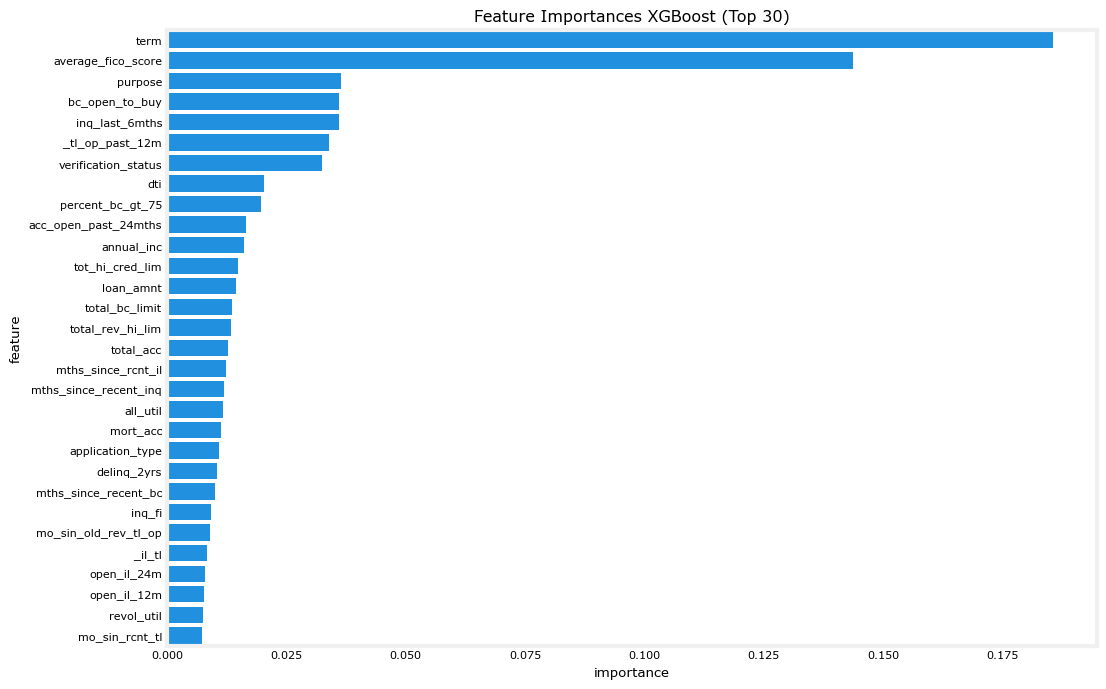

In [67]:
xgb_feature_importances = feature_importances['XGBoost']
plt.figure(figsize=(12, 8))
plt.title('Feature Importances XGBoost (Top 30)')
sns.barplot(xgb_feature_importances.head(30),
            x='importance',
            y='feature',
            color=default_blue)
plt.show()

- For our model preprocessing we followed a similar approach to as we did in the accepted/rejected notebook. As stated we utilized more simple methods of imputation due to the time/computational constraints. We also utilized target encoding as it made sense given some of our columns had high cardinality/geographical text data, which we assumed would be better represented with target encoding.
- During our initial model selection, we selected a few models with some default settings in order to get an understanding of which models perform best with our dataset. After initial evaluation, we observe that XGBoost (0.37) and Logistic Regression (0.30) performed the best in terms of f1-score.
- Our feature importance graph for our XGBoost model displays that features such as loan term and average fico score have the most importance, followed by purpose, total open to buy on revolving bankcards, number of credit inquiries in the past 6 months, and more. Now that we have identified which models are performing best and which features are most important, we will move forward with tuning XGBoost and performing some feature engineering and selection, as well as hyperparameter tuning.

**Hyperparameter Tuning (Grade)**

In [21]:
class_counts = np.bincount(y_train)
majority_class_count = np.max(class_counts)
class_weights = {
    i: majority_class_count / count
    for i, count in enumerate(class_counts)
}
weights = np.vectorize(class_weights.get)(y_train)

In [204]:
X_train_preprocessed = preprocessor_tree_based.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor_tree_based.transform(X_val)

In [49]:
objective = get_objective_xgb_multi_class(X_train_preprocessed,
                                          X_val_preprocessed, y_train, y_val,
                                          f1_score, weights)

In [52]:
optuna.logging.get_logger("optuna").setLevel(logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=75)

In [53]:
study.best_value

0.3915356605914656

In [54]:
study.best_params

{'use_class_weights': True,
 'n_estimators': 498,
 'learning_rate': 0.04287662662599042,
 'max_depth': 12,
 'min_child_weight': 3,
 'subsample': 0.7013625350247319,
 'colsample_bytree': 0.8703689768875603,
 'lambda': 0.7132538804149275,
 'alpha': 0.69426278737899}

In [71]:
best_params = {
    param_name.replace('xgb_', ''): value
    for param_name, value in study.best_params.items()
    if param_name != 'use_class_weights'
}
xgb_fixed_params = {
    "eval_metric": "mlogloss",
    "use_label_encoder": False,
    "objective": "multi:softmax",
    "n_jobs": -1,
    "random_state": 42,
}

In [24]:
xgb_model_v1 = xgb.XGBClassifier(**xgb_fixed_params, **best_params)
xgb_pipeline_v1 = create_pipeline(xgb_model_v1, preprocessor_tree_based, None)

In [56]:
xgb_pipeline_v1.fit(X_train, y_train, classifier__sample_weight=weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.7132538804149275,
                               learning_rate=0.04287662662599042, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=498, n_jobs=-1, ...))])

In [58]:
y_preds = xgb_pipeline_v1.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70     32314
           1       0.53      0.54      0.54     49487
           2       0.50      0.41      0.45     48407
           3       0.36      0.34      0.35     24129
           4       0.27      0.36      0.31     10095
           5       0.24      0.30      0.27      3112
           6       0.21      0.09      0.12       901

    accuracy                           0.50    168445
   macro avg       0.40      0.40      0.39    168445
weighted avg       0.50      0.50      0.50    168445



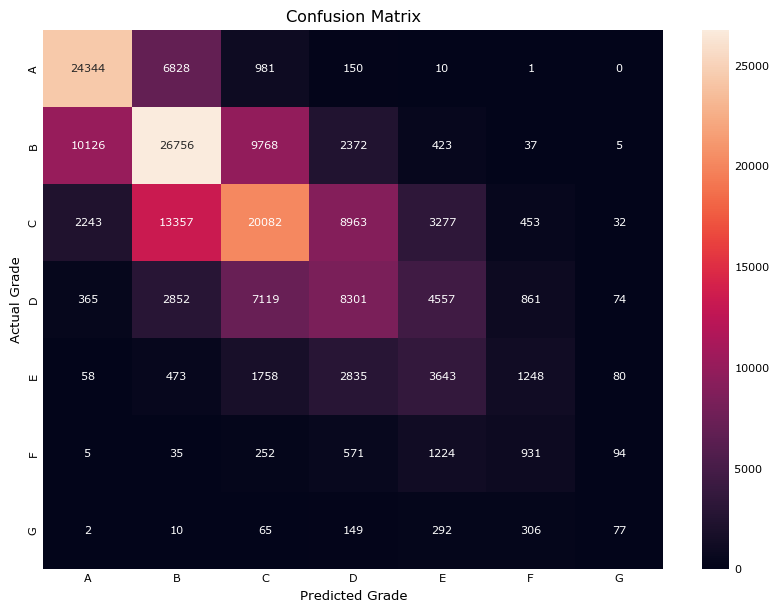

In [80]:
conf_matrix = confusion_matrix(y_val, y_preds_xgb_v1)
labels = sorted(df_accepted_subset['grade'].unique())
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Grade')
plt.xlabel('Predicted Grade')
plt.show()

In [37]:
xgb_ft_importances_tuned = extract_feature_importances(xgb_pipeline_v1)
xgb_ft_importances_tuned['feature'] = xgb_ft_importances_tuned[
    'feature'].str.replace(
        "^__", "", regex=True).map(lambda x: cat_cols_mapping.get(x, x))

In [39]:
xgb_ft_importances_tuned.head()

,feature,importance
1,term,0.335953
71,average_fico_score,0.043764
73,verification_status,0.024858
74,purpose,0.023083
6,inq_last_6mths,0.021894


- After our initial model evaluation, we went ahead and decided on our XGBoost model to move forward with. We performed an initial hyperparameter tuning using Optuna. As we can see, our macro f1-score increased to around 39%. Our confusion matrix displays that the model performs decently well in predicting grades A, B, and C  but starts to decline with more risky grades. We also re-evaluated our feature importance, which displayed pretty similar importances as our original model. Moving forward, we will be using a threshold (the 25th percentile) with the feature importance in order to test how our model would perform with slightly fewer features that are less important.

**Reducing Features Based On Importance (Grade)**

In [40]:
top_features = xgb_ft_importances_tuned[
    xgb_ft_importances_tuned['importance'] >
    xgb_ft_importances_tuned['importance'].quantile(0.25)]['feature'].values

In [41]:
print(f"{xgb_ft_importances_tuned.shape[0]} features before removing")
print(f"{top_features.shape[0]} after before removing")

78 features before removing
58 after before removing


In [44]:
X_train_top_features = X_train[top_features]
X_val_top_features = X_val[top_features]
numerical_top, cat_top = get_numerical_categorical_columns(
    X_train_top_features)
preprocessor_top_features = create_preprocessor(numerical_top, cat_top,
                                                numerical_imputer, cat_imputer,
                                                encoder, None)

In [46]:
xgb_model_v2_pipeline = create_pipeline(
    xgb.XGBClassifier(**xgb_fixed_params, **best_params),
    preprocessor_top_features, None)
xgb_model_v2_pipeline.fit(X_train_top_features,
                          y_train,
                          classifier__sample_weight=weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['term', 'average_fico_score', 'inq_last_6mths', 'num_tl_op_past_12m',
       'num_tl_30dpd', 'open_il_12m', 'acc_now_delinq', 'bc_open_to_buy',
       'loan_amnt', 'delinq_amnt', 'dti', 'acc_open_past_24m...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.7132538804149275,
                               learning_rate=0.04287662662599042, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=498, n_jobs=-1, ...))])

In [47]:
y_preds = xgb_model_v2_pipeline.predict(X_val_top_features)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.65      0.75      0.70     32314
           1       0.53      0.54      0.53     49487
           2       0.50      0.41      0.45     48407
           3       0.35      0.35      0.35     24129
           4       0.27      0.36      0.31     10095
           5       0.23      0.30      0.26      3112
           6       0.17      0.09      0.11       901

    accuracy                           0.50    168445
   macro avg       0.39      0.40      0.39    168445
weighted avg       0.50      0.50      0.50    168445



In [48]:
print(f1_score(y_val, y_preds, average='macro'))

0.3885418334123174


- After reducing the number of features (removed 20) we had obtained from the feature importances, by removing features having an importance less than or equal to the 25th percentile, we observed a very small decrease in our f-1 score. This could indicate that these features were only contributing a very small amount to our model. Moving forward, we will be performing some feature engineering, tuning, and re-evaluating the results.

**Feature Engineering (Grade)**

In [20]:
# Binning features by quartile
X_train_new = X_train.copy()
X_val_new = X_val.copy()
columns_to_bin = [
    'average_fico_score', 'dti', 'annual_inc', 'loan_amnt', 'tot_hi_cred_lim',
    'total_il_high_credit_limit', 'total_bc_limit'
]
for col in columns_to_bin:
    X_train_new[f"{col}_binned"] = bin_by_quartiles(X_train_new, col)
    X_val_new[f"{col}_binned"] = bin_by_quartiles(X_val_new, col)
X_train_new, X_val_new = X_train_new.drop(
    columns=columns_to_bin), X_val_new.drop(columns=columns_to_bin)

In [23]:
new_numerical_cols, new_cat_cols = get_numerical_categorical_columns(
    X_train_new)
preprocessor_feature_engineered = create_preprocessor(new_numerical_cols,
                                                      new_cat_cols,
                                                      numerical_imputer,
                                                      cat_imputer, encoder,
                                                      None)

In [24]:
X_train_new_preprocessed = preprocessor_feature_engineered.fit_transform(
    X_train_new, y_train)
X_val_new_preprocessed = preprocessor_feature_engineered.transform(X_val_new)

In [26]:
objective_v2 = get_objective_xgb_multi_class(X_train_new_preprocessed,
                                             X_val_new_preprocessed, y_train,
                                             y_val, f1_score, weights)

In [30]:
study_v2 = optuna.create_study(direction='maximize')
study_v2.optimize(objective_v2, n_trials=75)

In [41]:
study_v2.best_params

{'use_class_weights': True,
 'n_estimators': 361,
 'learning_rate': 0.02042503409056458,
 'max_depth': 14,
 'min_child_weight': 2,
 'subsample': 0.7134878568623669,
 'colsample_bytree': 0.9787387014103112,
 'lambda': 0.05086052295331598,
 'alpha': 0.39068251613246247}

In [29]:
study_v2.best_value

0.3632894207982736

- We performed some feature engineering by binning certain features that were deemed important, such as average Fico score, credit limits, annual income, etc. That being said, the model's performance actually did not increase compared to our last tuned model. Therefore, moving forward, we will evaluate our original tuned model on our test set and move forward with that one.

**Final Model & Evaluation (Grade)**

In [61]:
y_preds = xgb_pipeline_v1.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71     32314
           1       0.53      0.54      0.54     49487
           2       0.50      0.42      0.46     48407
           3       0.35      0.35      0.35     24129
           4       0.27      0.36      0.31     10095
           5       0.24      0.30      0.26      3112
           6       0.21      0.09      0.12       901

    accuracy                           0.50    168445
   macro avg       0.40      0.40      0.39    168445
weighted avg       0.50      0.50      0.50    168445



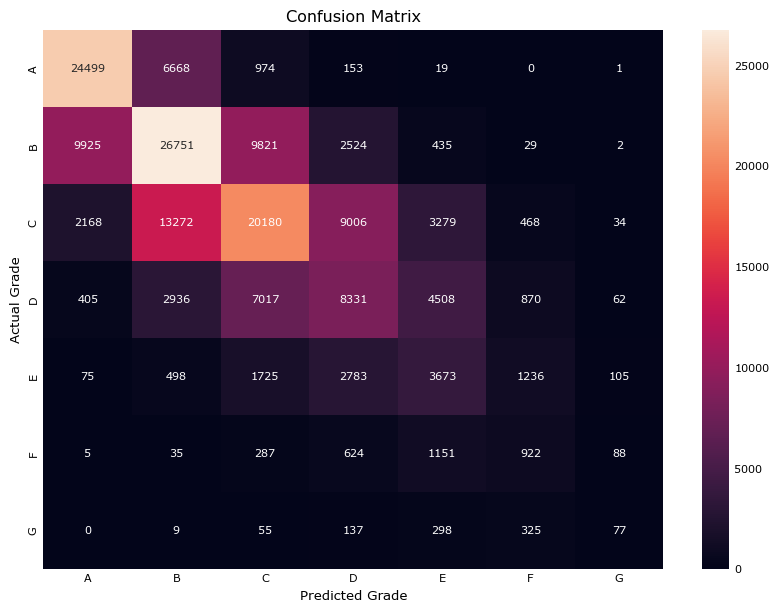

In [62]:
labels = sorted(df_accepted_subset['grade'].unique())
conf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Grade')
plt.xlabel('Predicted Grade')
plt.show()

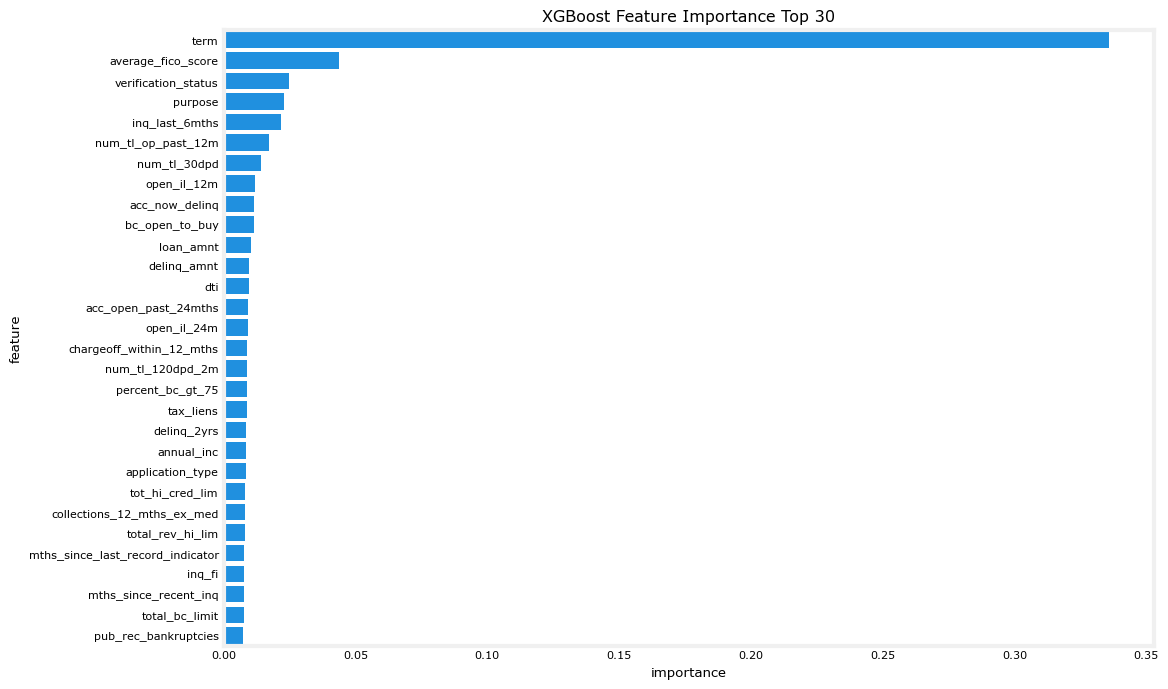

In [63]:
plt.figure(figsize=(12, 8))
plt.title('XGBoost Feature Importance Top 30')
sns.barplot(xgb_ft_importances_tuned.head(30),
            x='importance',
            y='feature',
            color=default_blue)
plt.show()

**Saving Model & Testing Data**

In [64]:
model_filename = 'xgb_pipeline_grade.joblib'

dump(xgb_pipeline_v1, model_filename)

['xgb_pipeline_grade.joblib']

- After various feature engineering/reduction techniques and hyperparameter tuning, we decided to go with our originally tuned XGBoost model. We proceeded by evaluating our final test set. The final model achieved an f1-score of 39%. As we can see from the classification report and confusion matrix, the model struggled with some of the less frequent or higher-risk grades. We utilized things such as class weights to try to make up for the class imbalance. Our feature importance shows that term was one of the biggest predictors, followed by average fico score and verification status. Overall, there is definitely room for improvement. Moving forward we will be following a similar approach for predicting subgrades.

### Loan Subgrades

**Objective**:  
Following the automation of loan grade classifications, we are now moving on to our next task, which involves predicting the subgrades for our accepted loans. Within each loan grade there are five sub-grades meaning there are 35 total loan grades for borrowers from A1 down to G5. This task will adopt a similar strategy to what we did in our model above for predicting loan grade.

In [20]:
# Create subgrade mapping (A1 --> 0 , etc)
subgrade_mapping = {
    f"{grade}{subgrade}": index
    for index, (grade, subgrade) in enumerate(
        (g, s) for g in 'ABCDEFG' for s in range(1, 6))
}

In [21]:
df_accepted_subset['subgrade_ordinal_encoded'] = df_accepted_subset[
    'sub_grade'].map(subgrade_mapping)

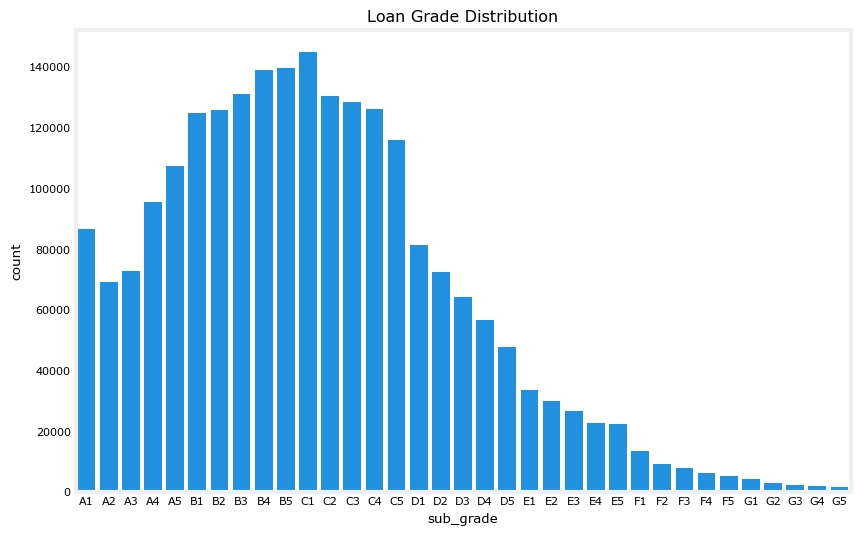

In [111]:
plt.figure(figsize=(10, 6))
plt.title('Loan Grade Distribution')
fig = sns.countplot(df_accepted_subset,
                    x='sub_grade',
                    color=default_blue,
                    order=sorted(df_accepted_subset['sub_grade'].unique()))

plt.show()

- Our plot above displays the loan sub-grade distribution in our dataset. We are working with a 35 distinct classes here (A1 --> G5). We also observe there is a big imbalance across classes, as the risk gets higher the amount of data points for that class tends to decrease. This indicates that these higher risk sub grades tend to occur less frequent.

**Correlation**

In [120]:
subset = df_accepted_subset.sample(
    frac=0.3,
    random_state=42).select_dtypes(exclude=['object', 'datetime64']).drop(
        columns=['fico_range_low', 'fico_range_high', 'int_rate'])
subset_without_sub_grade = subset.iloc[:, :-2]
spearmans_corr_subgrade = subset_without_sub_grade.corrwith(
    subset['subgrade_ordinal_encoded'], method='spearman')

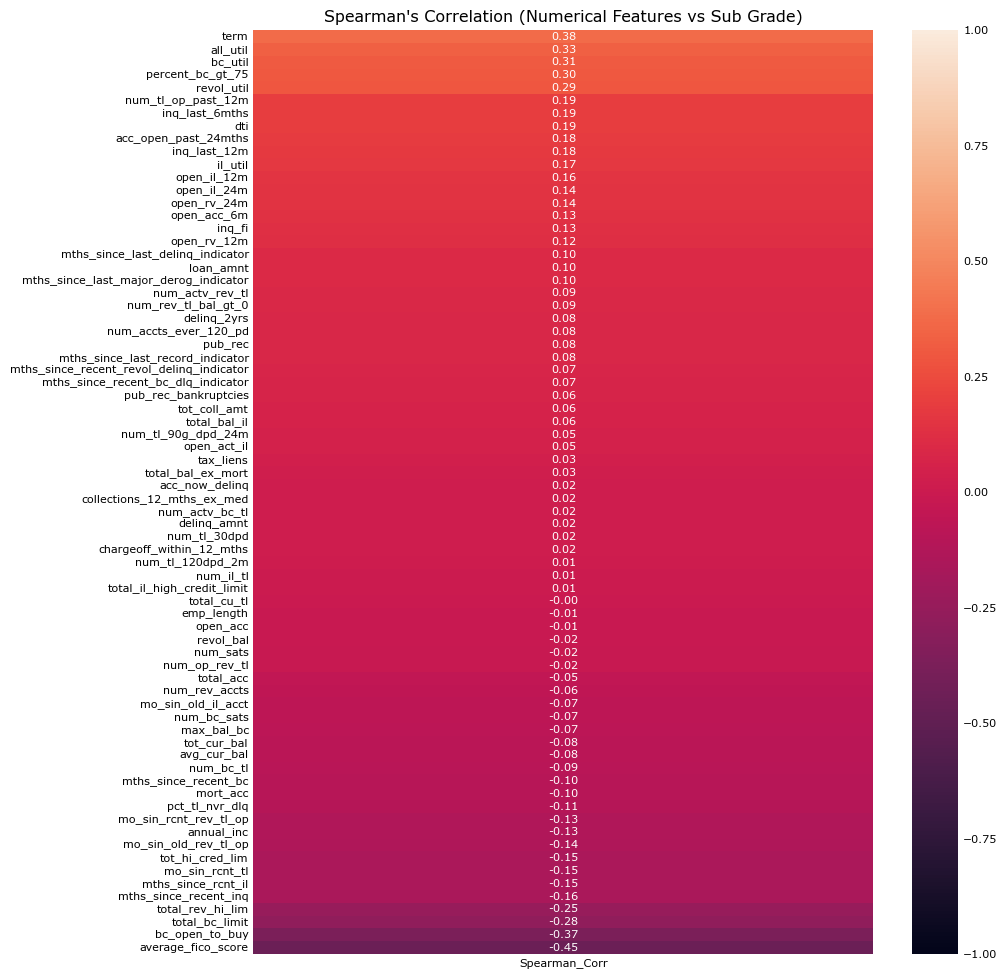

In [121]:
corr_matrix = pd.DataFrame(spearmans_corr_subgrade,
                           columns=['Spearman_Corr'
                                    ]).sort_values(by='Spearman_Corr',
                                                   ascending=False)

# Plot heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Spearman's Correlation (Numerical Features vs Sub Grade)")
plt.show()

- Taking a similar approach as we did the the grade, we plotted a correlation matrix (spearman) of our numerical features vs sub grade. It is almost identical as our correlation matrix for grade, which makes sense since they are one of the same. 

**Data Splitting/Preprocessing (Sub Grade)**

In [22]:
X = df_accepted_subset.drop(columns=[
    'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'emp_title',
    'int_rate', 'subgrade_ordinal_encoded', 'sub_grade',
    'grade_ordinal_encoded'
])
y = df_accepted_subset['subgrade_ordinal_encoded']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.075,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.075 /
                                                  (1 - 0.075),
                                                  random_state=42)

In [131]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_val)
print(classification_report(y_val, dummy_preds))

              precision    recall  f1-score   support

           0       0.04      0.04      0.04      6482
           1       0.03      0.03      0.03      5191
           2       0.03      0.03      0.03      5457
           3       0.04      0.04      0.04      7149
           4       0.05      0.05      0.05      8035
           5       0.05      0.06      0.06      9348
           6       0.06      0.06      0.06      9441
           7       0.06      0.06      0.06      9814
           8       0.06      0.06      0.06     10428
           9       0.06      0.06      0.06     10455
          10       0.06      0.06      0.06     10872
          11       0.06      0.06      0.06      9769
          12       0.06      0.06      0.06      9616
          13       0.05      0.05      0.05      9465
          14       0.05      0.05      0.05      8684
          15       0.04      0.04      0.04      6091
          16       0.03      0.03      0.03      5424
          17       0.03    

- We have split out data once again in a similar manner as we have done for grade. We also used the dummy classifier to establish a baseline to work against.Once again we will be utilizing macro f1-score due to the importance of both precision and recall in predicting/identifying sub-grades. Our baseline model is performing pretty poorly with an macro f1-score of a bout 3%.

**Model Selection (Sub Grade)**

In [70]:
numerical_cols, cat_cols = get_numerical_categorical_columns(X_train)
preprocessor_tree_based_subgrade = create_preprocessor(numerical_cols,
                                                       cat_cols,
                                                       numerical_imputer,
                                                       cat_imputer, encoder,
                                                       None)

preprocessor_linear_subgrade = create_preprocessor(numerical_cols, cat_cols,
                                                   numerical_imputer,
                                                   cat_imputer, encoder,
                                                   StandardScaler())

In [86]:
models_subgrade = {
    model_name: model
    for model_name, model in models.items()
    if model_name not in ['LogisticRegression']
}

In [24]:
model_results, feature_importances = evaluate_models(
    models_subgrade, X_train, y_train, X_val, y_val,
    preprocessor_linear_subgrade, preprocessor_tree_based_subgrade)

In [88]:
results_df_subgrade = pd.DataFrame(
    model_results, index=['F1-Score', 'Precision',
                          'Recall']).T.reset_index().rename(columns={
                              'index': 'Model'
                          }).sort_values(by='F1-Score', ascending=False)

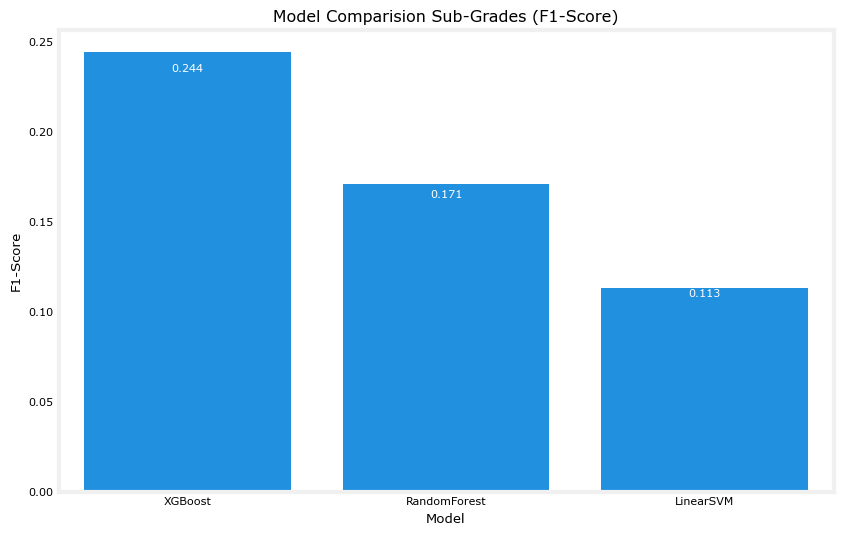

In [89]:
plt.figure(figsize=(10, 6))
plt.title('Model Comparision Sub-Grades (F1-Score)')
fig = sns.barplot(results_df_subgrade,
                  x='Model',
                  y='F1-Score',
                  color=default_blue)
annotate_bars(fig)
plt.show()

In [79]:
cat_cols_new_mapping = {str(i): cat_cols[i] for i in range(len(cat_cols))}

In [92]:
xgb_ft_importances = feature_importances['XGBoost']
xgb_ft_importances['feature'] = xgb_ft_importances['feature'].str.replace(
    "^__", "", regex=True).map(lambda x: cat_cols_new_mapping.get(x, x))

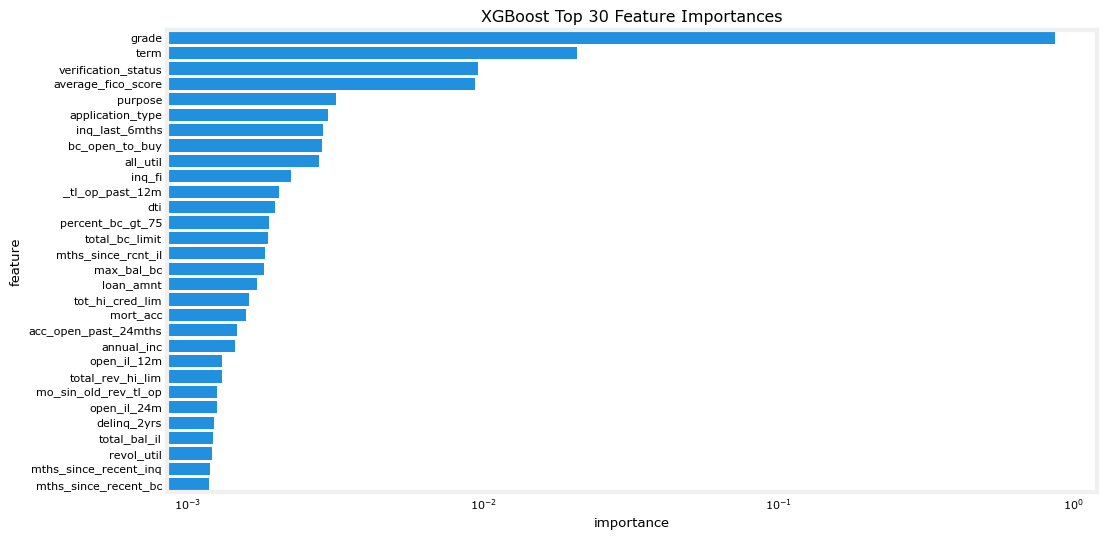

In [96]:
plt.figure(figsize=(12, 6))
plt.title('XGBoost Top 30 Feature Importances')
sns.barplot(xgb_ft_importances.head(30),
            x='importance',
            y='feature',
            color=default_blue)
plt.xscale('log')
plt.show()

- In our initial model selection , we opted to exclude logistic regression due to its extensive computational demands, particularly in predicting across 35 classes. From our initial evaluations, XGBoost performed the best achieving a macro F1-score of 24.4%. Utilizing the model's feature importance, it's clear that grade is the most significant predictor of sub-grade, which is logical given their hierarchical relationship. This was followed by term, verification status, and average FICO score in terms of predictive power. Moving forward, we plan to tune hyperparameters and perform feature engineering to further refine our model's performance.

**Hyperparmater Tuning (Sub Grade)**

In [73]:
class_counts = np.bincount(y_train)
majority_class_count = np.max(class_counts)
class_weights = {
    i: majority_class_count / count
    for i, count in enumerate(class_counts)
}
weights = np.vectorize(class_weights.get)(y_train)

In [102]:
X_train_preprocessed = preprocessor_tree_based_subgrade.fit_transform(
    X_train, y_train)
X_val_preprocessed = preprocessor_tree_based_subgrade.transform(X_val)

In [108]:
objective_xgb_subgrade = get_objective_xgb_multi_class(X_train_preprocessed,
                                                       X_val_preprocessed,
                                                       y_train,
                                                       y_val,
                                                       f1_score,
                                                       weights=weights)

In [111]:
study_xgb_subgrade = optuna.create_study(direction='maximize')
study_xgb_subgrade.optimize(objective_xgb_subgrade, n_trials=75)

In [112]:
study_xgb_subgrade.best_value

0.26126903083327585

In [114]:
study_xgb_subgrade.best_params

{'use_class_weights': True,
 'n_estimators': 424,
 'learning_rate': 0.06101546583832728,
 'max_depth': 9,
 'min_child_weight': 6,
 'subsample': 0.7078315724290474,
 'colsample_bytree': 0.8655707251984275,
 'lambda': 0.0001197124024415756,
 'alpha': 0.10029894079282065}

In [115]:
best_params_subgrade = {
    param_name.replace('xgb_', ''): value
    for param_name, value in study_xgb_subgrade.best_params.items()
    if param_name != 'use_class_weights'
}

In [72]:
best_params_subgrade = {
    'n_estimators': 424,
    'learning_rate': 0.06101546583832728,
    'max_depth': 9,
    'min_child_weight': 6,
    'subsample': 0.7078315724290474,
    'colsample_bytree': 0.8655707251984275,
    'lambda': 0.0001197124024415756,
    'alpha': 0.10029894079282065
}

In [74]:
xgb_model_subgrade_v1 = xgb.XGBClassifier(**xgb_fixed_params,
                                          **best_params_subgrade)
xgb_pipeline_subgrade_v1 = create_pipeline(xgb_model_subgrade_v1,
                                           preprocessor_tree_based_subgrade)
xgb_pipeline_subgrade_v1.fit(X_train,
                             y_train,
                             classifier__sample_weight=weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.0001197124024415756,
                               learning_rate=0.06101546583832728, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=424, n_jobs=-1, ...))])

In [75]:
y_preds = xgb_pipeline_subgrade_v1.predict(X_val)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.46      0.55      0.50      6482
           1       0.26      0.28      0.27      5191
           2       0.24      0.19      0.21      5457
           3       0.33      0.24      0.28      7149
           4       0.44      0.52      0.48      8035
           5       0.32      0.51      0.39      9348
           6       0.25      0.21      0.23      9441
           7       0.26      0.16      0.20      9814
           8       0.26      0.18      0.21     10428
           9       0.34      0.45      0.39     10455
          10       0.32      0.47      0.38     10872
          11       0.23      0.19      0.21      9769
          12       0.22      0.11      0.14      9616
          13       0.25      0.21      0.23      9465
          14       0.26      0.37      0.31      8684
          15       0.31      0.36      0.34      6091
          16       0.26      0.23      0.24      5424
          17       0.20    

In [80]:
xgb_ft_importance_tuned_subgrade = extract_feature_importances(
    xgb_pipeline_subgrade_v1)
xgb_ft_importance_tuned_subgrade['feature'] = xgb_ft_importance_tuned_subgrade[
    'feature'].str.replace(
        "^__", "", regex=True).map(lambda x: cat_cols_new_mapping.get(x, x))

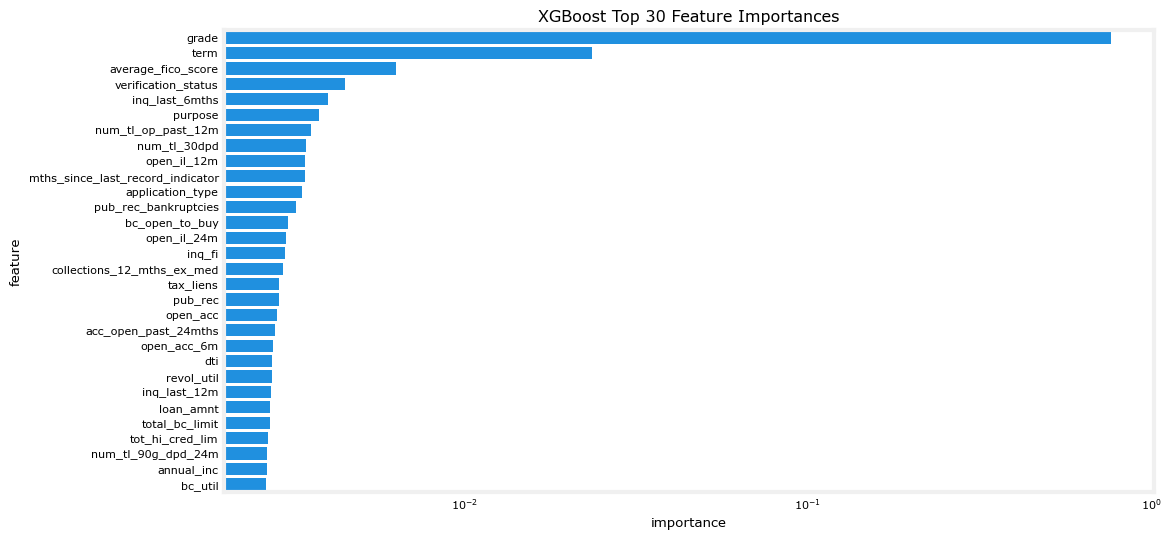

In [82]:
plt.figure(figsize=(12, 6))
plt.title('XGBoost Top 30 Feature Importances')
sns.barplot(xgb_ft_importance_tuned_subgrade.head(30),
            x='importance',
            y='feature',
            color=default_blue)
plt.xscale('log')
plt.show()

- Our initial hyperparameter tuning resulted in a slight increase in our f1-macro score, achieving approximately 26%. From our classification report we also get a more detailed overview of how our model is performing through out the various classes. Feature importance shows that grade (obviously), term, and average fico score carry the most importance for our model. Moving forward we will be reducing the amount of features based on the importance and reevaluating our models performance.

**Reducing Features Based On Importance and Evaluating (Sub Grade)**

In [83]:
top_features_subgrade = xgb_ft_importance_tuned_subgrade[
    xgb_ft_importance_tuned_subgrade['importance'] >
    xgb_ft_importance_tuned_subgrade['importance'].quantile(
        0.25)]['feature'].values

In [85]:
print(f"{xgb_ft_importance_tuned_subgrade.shape[0]} features before removing")
print(f"{top_features_subgrade.shape[0]} after before removing")

79 features before removing
59 after before removing


In [86]:
X_train_top_features = X_train[top_features_subgrade]
X_val_top_features = X_val[top_features_subgrade]
numerical_top, cat_top = get_numerical_categorical_columns(
    X_train_top_features)
preprocessor_top_features = create_preprocessor(numerical_top, cat_top,
                                                numerical_imputer, cat_imputer,
                                                encoder, None)

In [150]:
xgb_pipline_reduced_features = create_pipeline(
    xgb.XGBClassifier(**xgb_fixed_params, **best_params_subgrade),
    preprocessor_top_features)
xgb_pipline_reduced_features.fit(X_train_top_features_preprocessed,
                                 y_train,
                                 classifier__sample_weight=weights)

In [149]:
y_preds = xgb_pipline_reduced_features.predict(X_val)
print(f1_score(y_val, y_preds, average='macro'))

0.09629706464669548


- After reducing the amount of features based on feature importance and re-evaluating our model, we can see our f1-score has actually dropped pretty drastically, indicating that even though some of those features showed low importance, the interaction between features could have been significantly contributing out model. Moving forward we will be performing some feature engineering and re-tuning on those new features.

**Feature Engineering (Sub Grade)**

In [157]:
X_train_new = X_train.copy()
X_val_new = X_val.copy()
columns_to_bin = [
    'average_fico_score', 'dti', 'annual_inc', 'loan_amnt', 'tot_hi_cred_lim',
    'total_il_high_credit_limit', 'total_bc_limit', 'total_bal_il'
]
for col in columns_to_bin:
    X_train_new[f"{col}_binned"] = bin_by_quartiles(X_train_new, col)
    X_val_new[f"{col}_binned"] = bin_by_quartiles(X_val_new, col)
X_train_new, X_val_new = X_train_new.drop(
    columns=columns_to_bin), X_val_new.drop(columns=columns_to_bin)

In [158]:
new_numerical_cols, new_cat_cols = get_numerical_categorical_columns(
    X_train_new)
preprocessor_feature_engineered = create_preprocessor(new_numerical_cols,
                                                      new_cat_cols,
                                                      numerical_imputer,
                                                      cat_imputer, encoder,
                                                      None)
X_train_new_preprocessed = preprocessor_feature_engineered.fit_transform(
    X_train_new, y_train)
X_val_new_preprocessed = preprocessor_feature_engineered.transform(X_val_new)

In [159]:
objective_xgb_subgrade_v2 = objective_xgb_subgrade = get_objective_xgb_multi_class(
    X_train_new_preprocessed,
    X_val_new_preprocessed,
    y_train,
    y_val,
    f1_score,
    weights=weights)

In [164]:
study_xgb_subgrade_v2 = optuna.create_study(direction='maximize')
study_xgb_subgrade_v2.optimize(objective_xgb_subgrade, n_trials=50)

In [161]:
study_xgb_subgrade_v2.best_value

0.25705770198353395

In [163]:
study_xgb_subgrade_v2.best_params

{'use_class_weights': True,
 'n_estimators': 241,
 'learning_rate': 0.0375766538044624,
 'max_depth': 9,
 'min_child_weight': 3,
 'subsample': 0.6495148946168128,
 'colsample_bytree': 0.9174737643942026,
 'lambda': 0.1403679054845659,
 'alpha': 0.8466228483040933}

- After binning some of our important columns by quartiles and re running our hyperparameter tuning the results were slightly lower than our initial model (f1-score of 25.7%) with the original features. Therefore, moving forward we will be using the originally tuned model and evaluating on our test set.

**Final Model & Evaluation (Sub Grade)**

In [87]:
y_preds = xgb_pipeline_subgrade_v1.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.45      0.54      0.49      6482
           1       0.26      0.27      0.27      5191
           2       0.24      0.18      0.21      5457
           3       0.33      0.24      0.28      7149
           4       0.44      0.53      0.48      8035
           5       0.32      0.51      0.40      9348
           6       0.25      0.21      0.23      9441
           7       0.25      0.15      0.19      9814
           8       0.27      0.19      0.22     10428
           9       0.34      0.44      0.39     10455
          10       0.32      0.47      0.38     10873
          11       0.24      0.19      0.21      9769
          12       0.22      0.11      0.14      9616
          13       0.26      0.21      0.23      9465
          14       0.26      0.37      0.31      8684
          15       0.31      0.36      0.33      6091
          16       0.25      0.23      0.24      5424
          17       0.22    

**Saving Model & Testing Data**

In [88]:
dump(xgb_pipeline_subgrade_v1, 'xgboost_pipeline_subgrade.joblib')

['xgboost_pipeline_subgrade.joblib']

After various feature engineering/reduction techniques and hyperparameter tuning, our final model evaluation on the untouched test set resulted  in an f1-score of 26%.

**Conclusion**:

Our initial analysis provided insights into the relationship between various features and the grade/subgrade of a loan, identifying key factors such as the term of the loan, average FICO score, verification status, etc. Through testing multiple models and employing techniques like feature binning, importance reduction, and hyperparameter tuning, we achieved an f1-score of 39% for loan grades and 26% for sub grades. From a business perspective,despite the models not performing at their best, automation of this process could lead to time and cost-saving measure for the business, while also enhancing our understanding of the factors influencing loan classification.

**Suggestions for Improvement**:

Some challenges we faced were related to limitations in computing power, time, and data availability of minority classes. Some ways we could improve would be, extensive hyperparameter tuning, exploring different preprocessing techniques, and augmenting our dataset with more examples of rare grades could potentially enhance our models. Additionally, for the complex task of predicting 35 distinct classes, further feature engineering and data collection could defintley improve the models abilitiy to learn.